In [245]:
import pandas as pd
import os
import glob
import time
import numpy as np
import seaborn as sb
import re

import json

from tqdm import tqdm
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [280]:
def timems():
    return round(time.time() * 1000)

def merge_windows(wins):
    a = [wins[0]]
    for i in range(len(wins)-1):
        prev = a[len(a)-1]
        next = wins[i+1]
        if prev[1] + 1 >= next[0]:
            a[len(a)-1] = (a[len(a)-1][0], next[1])
        else:
            a.append(next)
    return a

def parse_fasta(protein_fasta):
    id = protein_fasta.split("\n")[0]
    sequence = ''.join(protein_fasta.split("\n")[1:])
    return (id, sequence)

def read_stride(path):
    data = []
    with open(path, "r") as f:
        for line in f.readlines():
            if line[:3] == "ASG":
                data.append(re.split("\s+", line)[6])
    return data
    
DSSP_STABLE = ["H", "B", "G", "I", "P"]

def read_dssp(path):
    data = None
    with open(path, "r") as f:
        line = f.readline().strip()
        while line[0] != '#':
            line = f.readline().strip()

        data = pd.read_csv(StringIO(f"#1 #2 residue AA structure\n" + f.read()),
            header=0, sep=r"\s+", usecols=[0,1,2,3,4]).structure

    is_stable = []
    for code in data:
        is_stable.append(code in DSSP_STABLE)
    return is_stable

def get_representatives(workdir):
    reps = {}
    files = sorted(glob.glob(os.path.join(workdir, "clean", "*.fasta")))
    for file in files:
        with open(file, "r") as f:
            id = f.readline().split()[0].split("|")[1]
            seq = f.readline().strip()
            reps[id] = seq
    return reps

In [284]:
flex = ["Coil", "Strand", "Turn"]

class RepSequence():
    def __init__(self, accession, sequence, work_dir, stride_path, cluster_windows):
        self.accession = accession
        self.sequence = sequence
        self.strides = read_stride(stride_path)
        self.dssp = read_dssp(os.path.join(work_dir, "dssp", f"{accession}.out"))
        self.window_counts = self.count_safe_bases(cluster_windows)

    def count_safe_bases(self, cluster_windows):
        counts = np.zeros(len(self.sequence), float)
        for rep_windows in cluster_windows:
            for start, end in merge_windows(rep_windows):
                for i in range(start, end):
                    assert i < len(counts), f"{self.accession} {rep_windows}"
                    counts[i] += 1
        counts = counts / len(cluster_windows)
        return counts

    def is_stable(self, i):
        return self.dssp[i]
        # return self.strides[i] not in flex

    def is_safe(self, i, th):
        return self.window_counts[i] >= th

    def safe_coverage(self, th):
        safes = 0
        for i in range(len(self.sequence)):
            safes += self.is_safe(i, th)
        return safes * 1.0 / len(self.sequence)

    def recall(self, th):
        stables = 0
        stables_in_safe = 0
        for i in range(len(self.sequence)):
            stables += self.is_stable(i)
            if self.is_safe(i, th): 
                stables_in_safe += self.is_stable(i)
        if stables == 0:
            return 0
        return stables_in_safe * 1.0 / stables

    def p_stable_in_safe(self, th):
        safes = 0
        stables_in_safe = 0
        for i in range(len(self.sequence)):
            if self.is_safe(i, th):
                safes += 1 
                stables_in_safe += self.is_stable(i)
        if safes == 0:
            return 0
        return stables_in_safe * 1.0 / safes
    
    def p_stable_out_safe(self, th):
        not_safes = 0
        stables_out_safe = 0
        for i in range(len(self.sequence)):
            if not self.is_safe(i, th):
                not_safes += 1
                stables_out_safe += self.is_stable(i)
        if not_safes == 0:
            return 0.0
        return stables_out_safe * 1.0 / not_safes

def get_all_clusters(path, alphas, deltas, reps):
    groups = {}
    for alpha in alphas:
        for delta in deltas:
            print(f"{alpha} {delta}")
            groups[(alpha, delta)] = []
            df_path = os.path.join(path, "df", f"a{alpha}.d{delta}.csv")
            assert os.path.isfile(df_path), f"File not found: {df_path}"
            df = pd.read_csv(df_path, index_col=0)

            df["r_windows"] = df.r_windows.apply(json.loads)

            df = df[df.TP + df.FN > 0]
            df = df[df.TP + df.FP > 0]

            cluster_num = 1
            for rep_id in reps.keys():
                windows = df[df.ref == rep_id].r_windows
                groups[(alpha, delta)].append(
                    RepSequence(rep_id, reps[rep_id],
                    path,
                    glob.glob(os.path.join(path, "stride", "*", f"{rep_id}.out"))[0],
                    windows)
                )
                cluster_num += 1

    return groups

In [282]:
alphas = [50, 75, 99]
deltas = [0, 2, 4, 6, 8, 10, 15]
reps = get_representatives("./../out/sprot_filtered.20.multi-step")
groups = get_all_clusters("./../out/sprot_filtered.20.multi-step", alphas, deltas, reps)

50 0
50 2
50 4
50 6
50 8
50 10
50 15
75 0
75 2
75 4
75 6
75 8
75 10
75 15
99 0
99 2
99 4
99 6
99 8
99 10
99 15


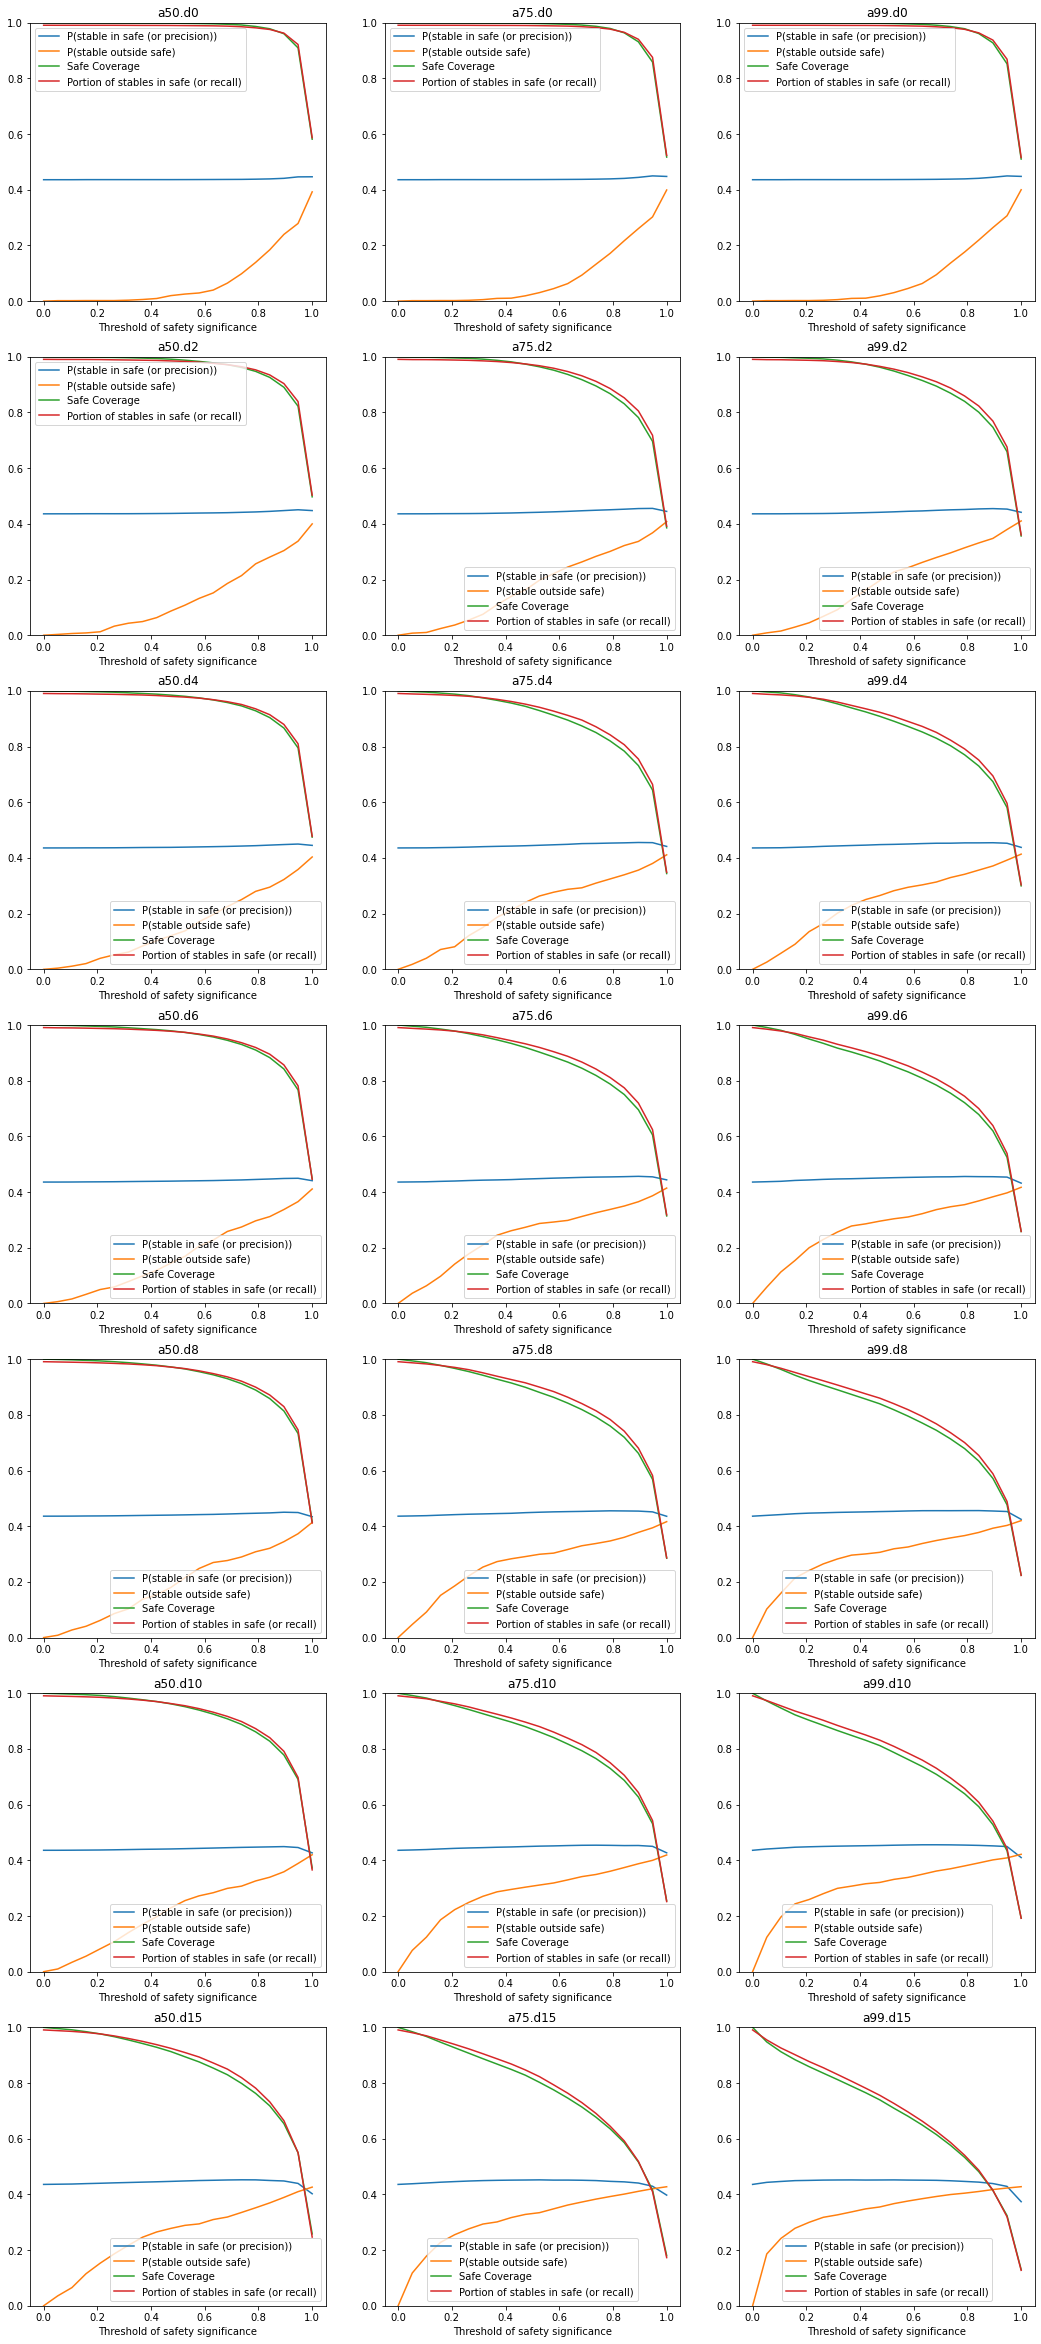

In [283]:
def plot_loss(groups, alphas, deltas):
    fig, ax = plt.subplots(nrows=len(deltas), ncols=len(alphas), figsize=(6*len(alphas), 6*len(deltas)))
    for j, d in enumerate(deltas):
        for i, a in enumerate(alphas):
            x = np.linspace(0, 1, 20)
            p_safe_in_stable = []
            p_safe_out_stable = []
            safe_coverages = []
            recalls = []
            for th in x:
                p_in = 0.0
                p_out = 0.0
                safe = 0.0
                recall = 0.0
                for rep in groups[(a, d)]:
                    p_in += rep.p_stable_in_safe(th)
                    p_out += rep.p_stable_out_safe(th)
                    safe += rep.safe_coverage(th)
                    recall += rep.recall(th)

                p_safe_in_stable.append(p_in/len(groups[(a,d)]))
                p_safe_out_stable.append(p_out/len(groups[(a,d)]))
                safe_coverages.append(safe/len(groups[(a,d)]))
                recalls.append(recall/len(groups[(a,d)]))

            ax[j][i].plot(x, p_safe_in_stable, label="P(stable in safe (or precision))")
            ax[j][i].plot(x, p_safe_out_stable, label="P(stable outside safe)")
            ax[j][i].plot(x, safe_coverages, label="Safe Coverage")
            ax[j][i].plot(x, recalls, label="Portion of stables in safe (or recall)")
            ax[j][i].set_title(f"a{a}.d{d}")
            ax[j][i].set_ylim([0,1])
            ax[j][i].set_xlabel("Threshold of safety significance")
            ax[j][i].legend()
    plt.show()

plot_loss(groups, alphas, deltas)     
            